# Titanic: Machine Learning from Disaster
## Use machine learning to predict survival on the Titanic
### Date: 2019-07-06
### Name: Eason Chen
### Github: [YCHEN-NYU](https://github.com/YCHEN-NYU)

* Load Packages
* Discription of dataset
    * Data Dictionary
    * Variable Notes
* Load and preprocess dataset
    * Load Dataset
    * Outliner Detector
    * Overview of Dataset
* Statistics of different features
    * Passenger Class
    * Sex
    * Age
    * Fare
    * Parents + Childrens
    * Siblings + Spouses
    * Embarkation
    * Survival
    * Correlation Matrix
* Classification
    * SGD
    * Random Forest
    * KNeighbors

In [882]:
# import packages
from __future__ import print_function, division, absolute_import

import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import Counter
from sklearn import svm  #for Support Vector Machine (SVM) Algorithm
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%matplotlib inline

## Load Dataset
### Data Dictionary
<table>
<tbody>
<tr><th><b>Variable</b></th><th><b>Definition</b></th><th><b>Key</b></th></tr>
<tr>
<td>survival</td>
<td>Survival</td>
<td>0 = No, 1 = Yes</td>
</tr>
<tr>
<td>pclass</td>
<td>Ticket class</td>
<td>1 = 1st, 2 = 2nd, 3 = 3rd</td>
</tr>
<tr>
<td>sex</td>
<td>Sex</td>
<td></td>
</tr>
<tr>
<td>Age</td>
<td>Age in years</td>
<td></td>
</tr>
<tr>
<td>sibsp</td>
<td># of siblings / spouses aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>parch</td>
<td># of parents / children aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>ticket</td>
<td>Ticket number</td>
<td></td>
</tr>
<tr>
<td>fare</td>
<td>Passenger fare</td>
<td></td>
</tr>
<tr>
<td>cabin</td>
<td>Cabin number</td>
<td></td>
</tr>
<tr>
<td>embarked</td>
<td>Port of Embarkation</td>
<td>C = Cherbourg, Q = Queenstown, S = Southampton</td>
</tr>
</tbody>
</table>




### Variable Notes
* **pclass**: A proxy for socio-economic status (SES)
    * 1st = Upper
    * 2nd = Middle
    * 3rd = Lower

* **age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

* **sibsp**: The dataset defines family relations in this way...
    * Sibling = brother, sister, stepbrother, stepsister
    * Spouse = husband, wife (mistresses and fiancés were ignored)

* **parch**: The dataset defines family relations in this way...
    * Parent = mother, father
    * Child = daughter, son, stepdaughter, stepson
    * Some children travelled only with a nanny, therefore parch=0 for them.

In [952]:
df_train = pd.read_csv('train.csv')

## Drop outliners by Turkey method

In [960]:
# Outlier detection 

def outliner_detector(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        print('Q1 = ', Q1)
        
        print('Q3 = ', Q3)
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
outliner_indices = outliner_detector(df_train, 2, ["Age","SibSp","Parch","Fare"])

Q1 =  nan
Q3 =  nan
Q1 =  0.0
Q3 =  1.0
Q1 =  0.0
Q3 =  0.0
Q1 =  7.9104
Q3 =  31.0


/Users/yiyi/anaconda/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [961]:
df_train.iloc[outliner_indices]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [992]:
# drop off outliners detected by the above detector
df_train = df_train.drop(outliner_indices, axis = 0)

# drop off outliners with fare greater than 300
outliner_fare_indices = df_train['Fare'][df_train['Fare'] > 300].index
df_train = df_train.drop(outliner_fare_indices, axis = 0)

# drop off outliners with Parch greater than 5
outliner_parch_indices = df_train['Parch'][df_train['Parch'] > 5].index
df_train = df_train.drop(outliner_parch_indices, axis = 0)

In [993]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [994]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    877 non-null int64
Survived       877 non-null int64
Pclass         877 non-null int64
Name           877 non-null object
Sex            877 non-null object
Age            707 non-null float64
SibSp          877 non-null int64
Parch          877 non-null int64
Ticket         877 non-null object
Fare           877 non-null float64
Cabin          199 non-null object
Embarked       875 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 89.1+ KB


### There're some missing data associated with 'Age', 'Cabin', 'Embarked'

In [995]:
# statistical summary of some features
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,877.000000,877.000000,877.000000,707.000000,877.000000,877.000000,877.000000
mean,446.064994,0.384265,2.311288,29.689066,0.456100,0.356899,29.457482
std,256.693916,0.486698,0.833117,14.575773,0.872957,0.769934,38.962621
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,225.000000,0.000000,2.000000,20.000000,0.000000,0.000000,7.895800
50%,447.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.400000
75%,666.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.070800
max,891.000000,1.000000,3.000000,80.000000,5.000000,5.000000,263.000000


## An overview of the feature distributions


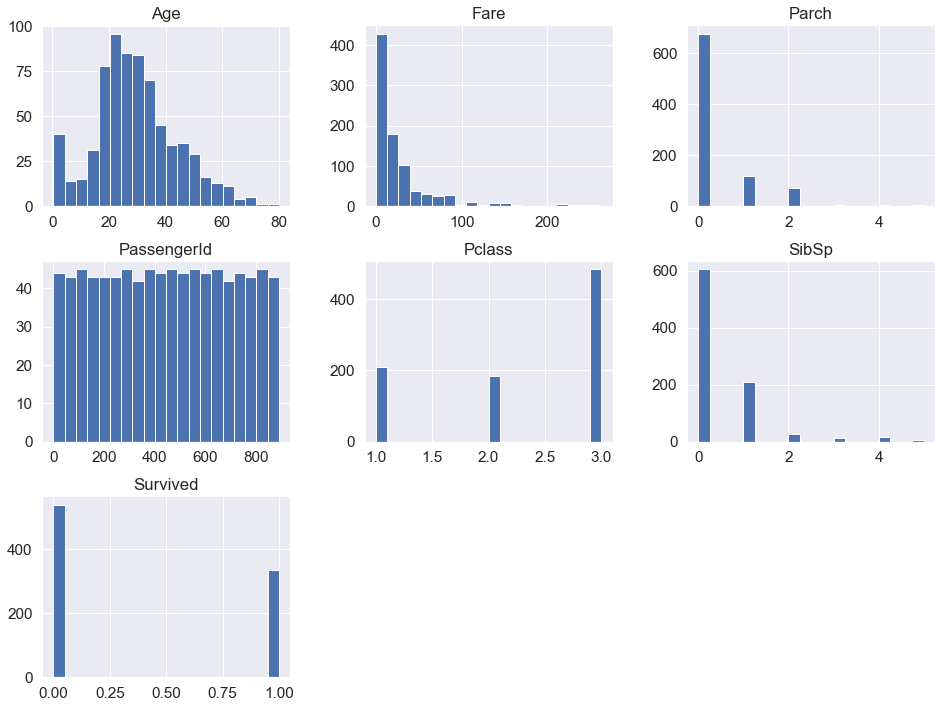

In [1059]:
df_train.hist(figsize=(16, 12), bins = 20, color = 'C0')
plt.show()

In [997]:
# column names
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Passenger Class Distribution
* **Pclass**: A proxy for socio-economic status (SES)
    * 1st = Upper
    * 2nd = Middle
    * 3rd = Lower

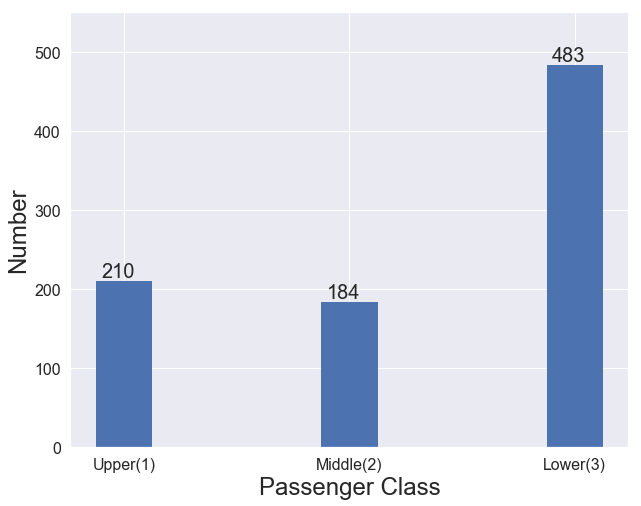

In [998]:
# Passenger class distribution
pclass_sum = (df_train['Pclass'].value_counts())
pclass_sum = pclass_sum.sort_index()


fig = plt.figure(figsize = (10, 8))
plt.bar(pclass_sum.index, pclass_sum, color='C0', width=.25, edgecolor = 'none')
plt.ylabel('Number', fontsize = 24)
plt.xlabel('Passenger Class', fontsize = 24)
plt.xticks([1., 2., 3], ['Upper(1)', 'Middle(2)', 'Lower(3)'], fontsize = 16)
plt.yticks([0, 100, 200, 300, 400, 500], fontsize = 16)
plt.ylim([0, 550])
for x, y in zip(pclass_sum.index, pclass_sum):
    plt.text(x - 0.1, y + 5, y, fontsize = 20)
plt.grid(True)
plt.savefig('./figures/Passenger_class_distribution.png')
plt.show()


### Passenger Sex Distributions

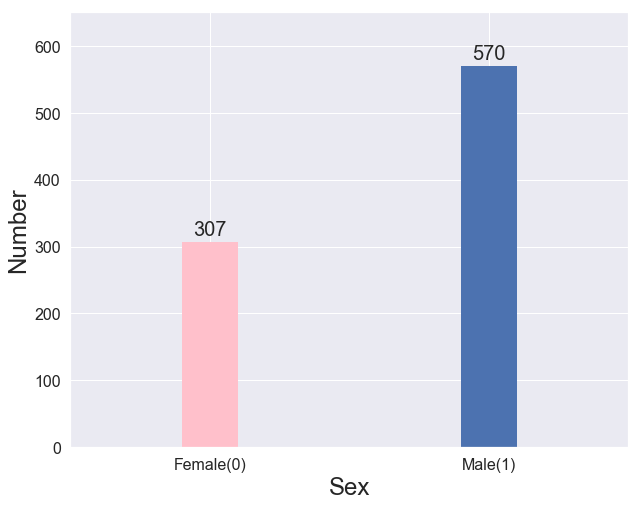

In [999]:
# Sex distribution
sex_sum = (df_train['Sex'].value_counts())
sex_sum = sex_sum.sort_index()

fig = plt.figure(figsize = (10, 8))
plt.bar(0, sex_sum.iloc[0], color= 'pink', width=.2, edgecolor = 'none')
plt.bar(1, sex_sum.iloc[1], color= 'b', width=.2, edgecolor = 'none')
plt.ylabel('Number', fontsize = 24)
plt.xlabel('Sex', fontsize = 24)
plt.xticks([0., 1.], ['Female(0)', 'Male(1)'], fontsize = 16)
plt.yticks([0, 100, 200, 300, 400, 500, 600], fontsize = 16)
plt.ylim([0, 650])
plt.xlim([-0.5, 1.5])
for x, y in zip([0, 1], sex_sum):
    plt.text(x, y + 10, y,  horizontalalignment='center', fontsize = 20)
plt.grid(True)
plt.savefig('./figures/Passenger_sex_distribution.png')
plt.show()


### Passenger Age Distribution
* **age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5


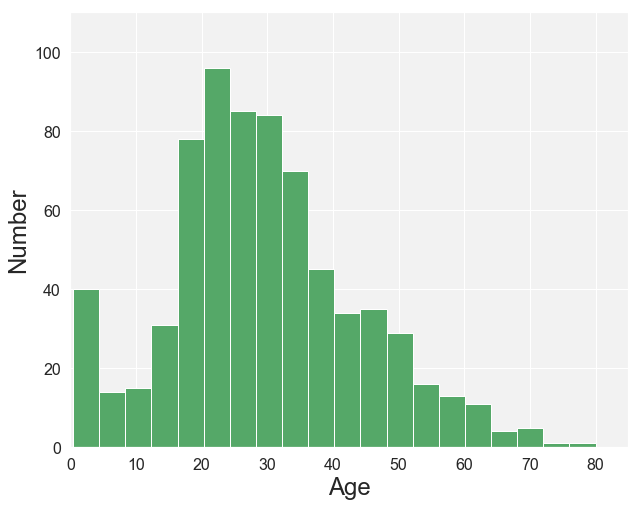

In [1000]:
# Age distribution
age_sum = (df_train['Age'].value_counts())
age_sum = age_sum.sort_index()

fig = plt.figure(figsize = (10, 8))
ax = sns.distplot(df_train['Age'].dropna(axis = 0), norm_hist=False, 
                  kde=False, color='C2', axlabel='Age', hist_kws=dict(alpha=1))
ax.set_facecolor([0.95, 0.95, 0.95])
ax.grid(True)
ax.set_xlabel('Age', fontsize = 24)
ax.set_ylabel('Number', fontsize = 24)
ax.xaxis.set_ticks(np.linspace(0, 100, 11))
ax.yaxis.set_ticks(np.linspace(0, 100, 6))
ax.fontsize = 24
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_ylim([0, 110])
ax.set_xlim(0, 85)
plt.savefig('./figures/Passenger_Age_Distribution.png')
plt.show()


### Passenger Ticket Fare Distribution

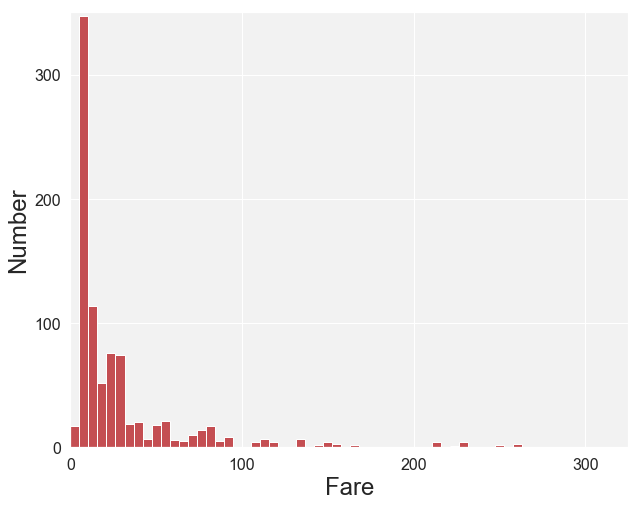

In [1001]:
# Fare distribution
fare_sum = (df_train['Fare'].value_counts())
fare_sum = fare_sum.sort_index()

fig = plt.figure(figsize = (10, 8))
ax = sns.distplot(df_train['Fare'], norm_hist=False, kde=False, color='C3', axlabel='Fare', hist_kws=dict(alpha=1))
ax.set_facecolor([0.95, 0.95, 0.95])
ax.grid(True)
ax.set_xlabel('Fare', fontsize = 24)
ax.set_ylabel('Number', fontsize = 24)
ax.xaxis.set_ticks(np.linspace(0, 300, 4))
ax.yaxis.set_ticks(np.linspace(0, 400, 5))
ax.fontsize = 24
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_ylim([0, 350])
ax.set_xlim([0, 325])
plt.savefig('./figures/Passenger_Fare_Distribution.png')
plt.show()


### Parents + Childrens
* **parch**: The dataset defines family relations in this way...
    * Parent = mother, father
    * Child = daughter, son, stepdaughter, stepson
    * Some children travelled only with a nanny, therefore parch=0 for them.

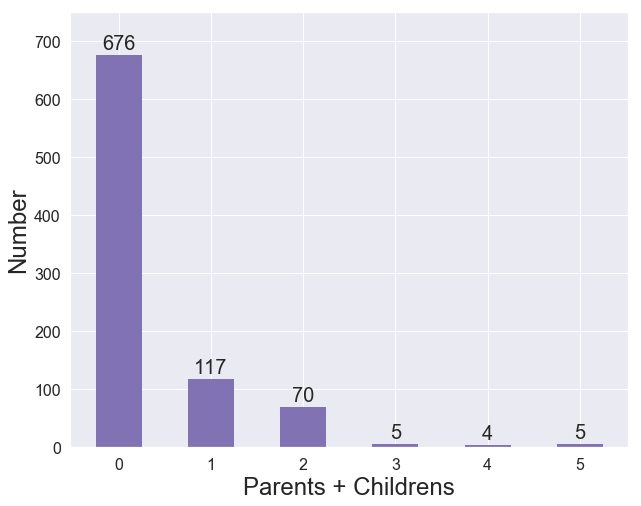

In [1002]:
# Fare distribution
parch_sum = (df_train['Parch'].value_counts())
parch_sum = parch_sum.sort_index()


fig = plt.figure(figsize = (10, 8))
plt.bar(parch_sum.index, parch_sum, color='C4', width=.5, edgecolor = 'none')
plt.ylabel('Number', fontsize = 24)
plt.xlabel('Parents + Childrens', fontsize = 24)
plt.xticks(parch_sum.index, fontsize = 16)
plt.yticks(np.linspace(0, 700, 8), fontsize = 16)
plt.ylim([0, 750])
for x, y in zip(parch_sum.index, parch_sum):
    plt.text(x, y + 10, y, horizontalalignment='center', fontsize = 20)
plt.grid(True)
plt.savefig('./figures/Passenger_Parch_distribution.png')
plt.show()


### Siblings + Spouse
* **sibsp**: The dataset defines family relations in this way...
    * Sibling = brother, sister, stepbrother, stepsister
    * Spouse = husband, wife (mistresses and fiancés were ignored)

In [1003]:
sibsp_sum

0    608
1    209
2     28
3     13
4     18
5      5
Name: SibSp, dtype: int64

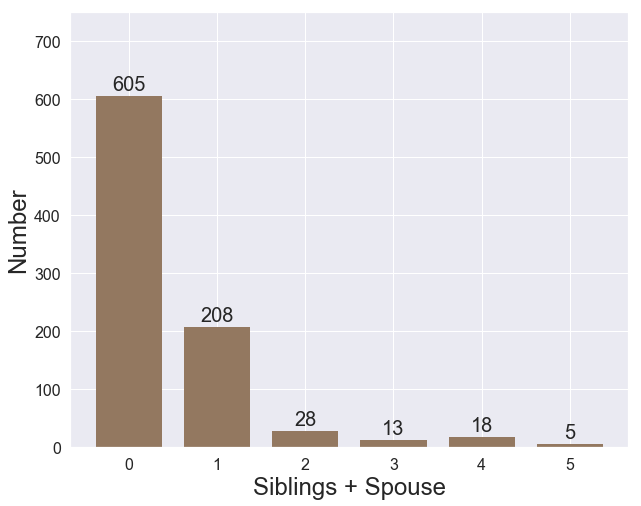

In [1005]:
# Fare distribution
sibsp_sum = (df_train['SibSp'].value_counts())
sibsp_sum = sibsp_sum.sort_index()


fig = plt.figure(figsize = (10, 8))
plt.bar(sibsp_sum.index, sibsp_sum, color='C5', width=.75, edgecolor = 'none')
plt.ylabel('Number', fontsize = 24)
plt.xlabel('Siblings + Spouse', fontsize = 24)
plt.xticks(np.linspace(0, 5, 6), fontsize = 16)
plt.yticks(np.linspace(0, 700, 8), fontsize = 16)

plt.ylim([0, 750])
for x, y in zip(sibsp_sum.index, sibsp_sum):
    plt.text(x, y + 10, y, horizontalalignment='center', fontsize = 20)
plt.grid(True)
plt.savefig('./figures/Passenger_SibSp_distribution.png')
plt.show()



### Port of Embarkation
    * C = Cherbourg
    * Q = Queenstown
    * S = Southampton

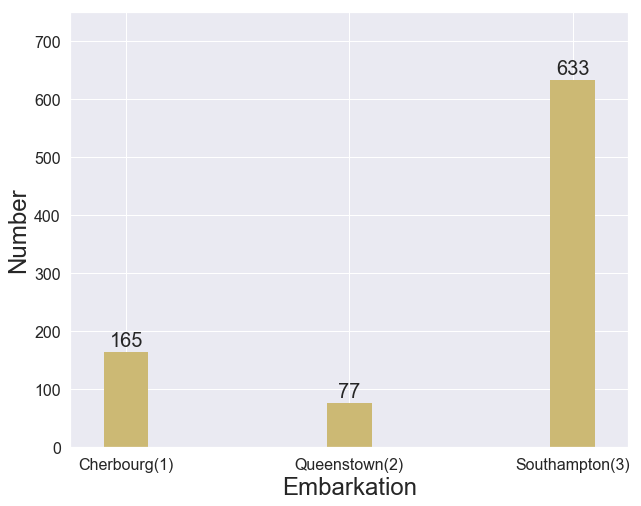

In [1006]:
# Embark distribution
#     * C = Cherbourg
#     * Q = Queenstown
#     * S = Southampton

embarked_sum = (df_train['Embarked'].value_counts())
embarked_sum = embarked_sum.sort_index()

fig = plt.figure(figsize = (10, 8))
plt.bar([1, 2, 3], embarked_sum, color='C8', width=.2, edgecolor = 'none')
plt.ylabel('Number', fontsize = 24)
plt.xlabel('Embarkation', fontsize = 24)
plt.xticks([1, 2, 3], ['Cherbourg(1)', 'Queenstown(2)', 'Southampton(3)'], fontsize = 16)
plt.yticks(np.linspace(0, 700, 8), fontsize = 16)
plt.ylim([0, 750])
plt.xlim([0.75, 3.25])
for x, y in zip([1, 2, 3], embarked_sum):
    plt.text(x, y + 10, y,  horizontalalignment='center', fontsize = 20)
plt.grid(True)
plt.savefig('./figures/Passenger_Embarkation_distribution.png')
plt.show()


### Survival Distribution

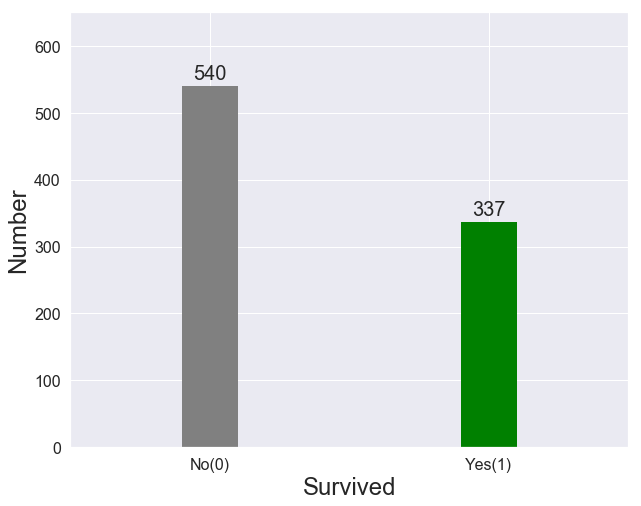

In [1007]:
# Survived distribution
survived_sum = (df_train['Survived'].value_counts())
survived_sum = survived_sum.sort_index()

fig = plt.figure(figsize = (10, 8))
plt.bar([0, 1], survived_sum, color='gray', width=.2, edgecolor = 'none')
plt.bar(1, survived_sum.iloc[1], color='green', width=.2, edgecolor = 'none')
plt.ylabel('Number', fontsize = 24)
plt.xlabel('Survived', fontsize = 24)
plt.xticks([0., 1.], ['No(0)', 'Yes(1)'], fontsize = 16)
plt.yticks(np.linspace(0, 600, 7), fontsize = 16)
plt.ylim([0, 650])
plt.xlim([-0.5, 1.5])
for x, y in zip([0, 1], survived_sum):
    plt.text(x, y + 10, y,  horizontalalignment='center', fontsize = 20)
plt.grid(True)
plt.savefig('./figures/Passenger_Survived_distribution.png')
plt.show()


### Convert the pandas.DataFrame into numpy.array
* **'[Sex', 'Embarked'] columns are transformed into categorical format **

In [1008]:
def clean_df(df, X_columns, y_columns, dropna_anyrow = False, shuffle=True,
                 random_seed = 101):
    if(shuffle):
        np.random.seed(random_seed)
        shuffled_indices = np.random.permutation(df.index)
        df = df.reindex(shuffled_indices)
    
    df = df[X_columns + y_columns]
    
    # categorize data
    sex_encoder = LabelEncoder()
    df['Sex'] = sex_encoder.fit_transform(df['Sex'])
    print('Sex Categories: ', sex_encoder.classes_)
    
    df = df.dropna(axis = 0)
    
    X = df[X_columns]
    y = df[y_columns]
    
    print('X.shape = ', X.shape)
    print('y.shape = ', y.shape)
    return X, y


In [1044]:
# feature columns
X_columns = ['Age', 'Fare', 'Parch', 'Pclass',  'Sex', 'SibSp']

# label columns
y_columns = ['Survived']

X_train, y_train = clean_df(df_train, X_columns=X_columns, 
                               y_columns=y_columns, dropna_anyrow=True,
                               random_seed = 101, shuffle=True)


Sex Categories:  ['female' 'male']
X.shape =  (707, 6)
y.shape =  (707, 1)


## Correlation Matrix

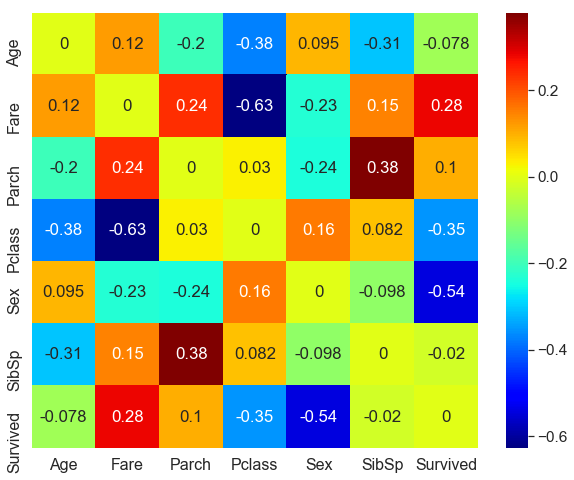

In [1047]:
def set_diagonal_to_zero(df):
    for index in df.index:
        df[index][index] = 0.0

# correlation matrix of the training data       
train_corr = pd.concat([X_train, y_train], axis = 1).corr()

# get a better contract by setting diagonal elements to zero
set_diagonal_to_zero(train_corr) 

fig = plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
ax = sns.heatmap(train_corr, annot=True, cmap = 'jet')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.show()

### Convert X_train, y_train into numpy.array format

In [1011]:
X_train = np.c_[X_train]
y_train = np.c_[y_train].flatten()

## Stochatic Gradient Descent Classifier

In [1012]:
sgd_clf = SGDClassifier(random_state=97)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=97, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [1013]:
def train(clf, X_train, y_train):
    clf.fit(X_train, y_train)
    random_index = np.random.randint(len(y_train))
    random_digit = X_train[random_index, :]
    random_digit_scores = clf.decision_function([random_digit])
    print('Random Digit Scores = ', random_digit_scores)
    print('Max Probability index = ', np.argmax(random_digit_scores))
    
def show_digit_with_label(digit, clf):
    plt.figure(figsize = (2, 2))
    plt.title('Label: ' + str(clf.predict([digit])[0]), fontsize = 20)
#     plt.imshow(digit.reshape(28, 28), cmap = 'binary')
    plt.axis('off')
    plt.show()

sgd_clf = SGDClassifier(random_state=101)
train(sgd_clf, X_train, y_train)

Random Digit Scores =  [-65.46140797]
Max Probability index =  0


## Cross Validation Score

In [1014]:
cross_val_score(sgd_clf, X_train, y_train, cv = 5, scoring='accuracy')

array([ 0.77464789,  0.76760563,  0.77304965,  0.64539007,  0.68794326])

In [1015]:
sgd_train_predictions = cross_val_predict(sgd_clf, X_train, y_train, cv = 3)
sgd_confusion_matrix = confusion_matrix(y_train, sgd_train_predictions)

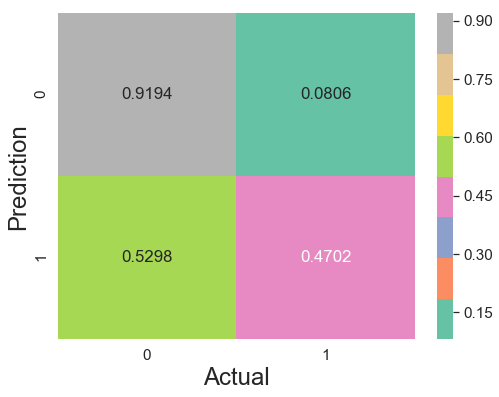

In [1041]:
row_sums = sgd_confusion_matrix.sum(axis = 1, keepdims = True)
confusion_matrix_normalized_col = sgd_confusion_matrix/row_sums

plt.figure(figsize = (8, 6))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix_normalized_col, cmap = 'Set2', annot=True, fmt = '.4f')
plt.xlabel('Actual', fontsize = 24)
plt.ylabel('Prediction', fontsize = 24)
plt.show()

## Random Forest Classifier

In [1017]:
def train(clf, X_train, y_train):
    clf.fit(X_train, y_train)
    random_index = np.random.randint(len(y_train))
    random_digit = X_train[random_index, :]
#     show_digit(random_digit, clf)
    random_digit_scores = clf.predict_proba([random_digit])
    print('Random Digit Scores = ', random_digit_scores)
    print('Max Probability index = ', np.argmax(random_digit_scores))
    
def show_digit_with_label(digit, clf):
    plt.figure(figsize = (2, 2))
    plt.title('Label: ' + str(clf.predict([digit])[0]), fontsize = 20)
#     plt.imshow(digit.reshape(28, 28), cmap = 'binary')
    plt.axis('off')
    plt.show()

rf_clf = RandomForestClassifier(random_state=97)
train(rf_clf, X_train, y_train)

Random Digit Scores =  [[ 0.1  0.9]]
Max Probability index =  1


/Users/yiyi/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [1018]:
cross_val_score(rf_clf, X_train, y_train, cv = 5, scoring='accuracy')

array([ 0.79577465,  0.84507042,  0.75886525,  0.78014184,  0.80851064])

In [1019]:
rf_train_predictions = cross_val_predict(rf_clf, X_train, y_train, cv = 5)
rf_confusion_matrix = confusion_matrix(y_train, rf_train_predictions)

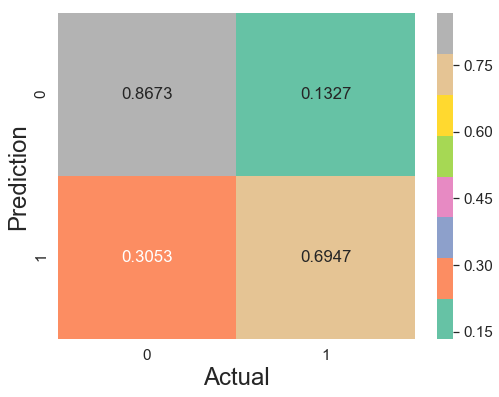

In [1039]:
row_sums = rf_confusion_matrix.sum(axis = 1, keepdims = True)
confusion_matrix_normalized_col = rf_confusion_matrix/row_sums
# np.fill_diagonal(confusion_matrix_normalized_col, 0)

plt.figure(figsize = (8, 6))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix_normalized_col, cmap = 'Set2', annot=True, fmt = '.4f')
plt.xlabel('Actual', fontsize = 24)
plt.ylabel('Prediction', fontsize = 24)
plt.show()

## KNeighbor Classifier

In [1021]:
def train(clf, X_train, y_train):
    clf.fit(X_train, y_train)
    random_index = np.random.randint(len(y_train))
    random_digit = X_train[random_index, :]
    random_digit_scores = clf.predict_proba([random_digit])
    print('Random Digit Scores = ', random_digit_scores)
    print('Max Probability index = ', np.argmax(random_digit_scores))
    
def show_digit_with_label(digit, clf):
    plt.figure(figsize = (2, 2))
    plt.title('Label: ' + str(clf.predict([digit])[0]), fontsize = 20)
    plt.imshow(digit.reshape(28, 28), cmap = 'binary')
    plt.axis('off')
    plt.show()

knn_clf = KNeighborsClassifier()
train(knn_clf, X_train, y_train)

Random Digit Scores =  [[ 0.6  0.4]]
Max Probability index =  0


In [1022]:
cross_val_score(knn_clf, X_train, y_train, cv = 5, scoring='accuracy')

array([ 0.68309859,  0.71126761,  0.70212766,  0.64539007,  0.71631206])

In [1023]:
train_predictions = cross_val_predict(knn_clf, X_train, y_train, cv = 5)
knn_confusion_matrix = confusion_matrix(y_train, train_predictions)

## Heat Map of normalized confusion matrix
## (diagonal elements zeroed)

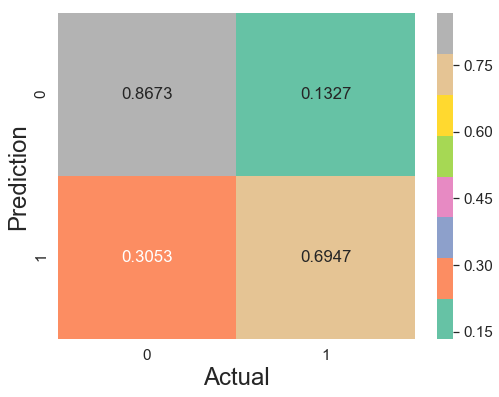

In [1040]:
row_sums = knn_confusion_matrix.sum(axis = 1, keepdims = True)
confusion_matrix_normalized_col = rf_confusion_matrix/row_sums
# np.fill_diagonal(confusion_matrix_normalized_col)

plt.figure(figsize = (8, 6))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix_normalized_col, cmap = 'Set2', annot=True, fmt = '.4f')
plt.xlabel('Actual', fontsize = 24)
plt.ylabel('Prediction', fontsize = 24)
plt.show()

In [1030]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms 
random_state = 101
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                      random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["SVC","DecisionTree","AdaBoost","RandomForest",
                                    "ExtraTrees","GradientBoosting","MultipleLayerPerceptron",
                                    "KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})



## Cross Validation Scores of different models

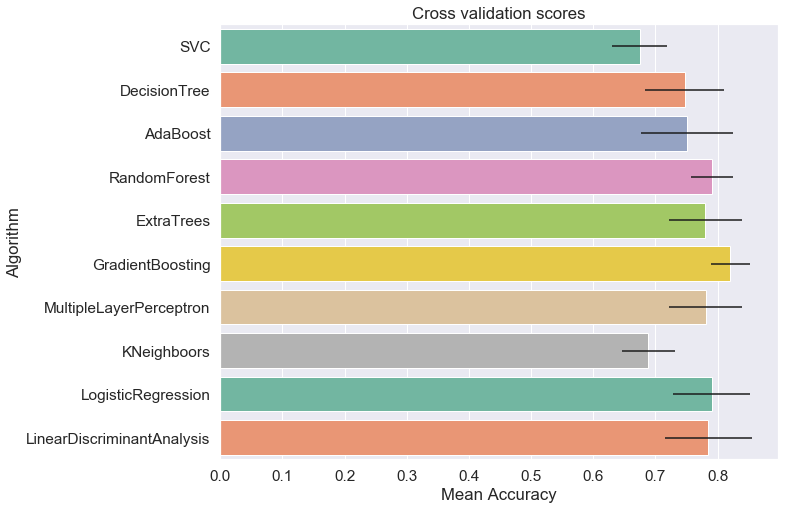

In [1031]:
fig = plt.figure(figsize = (10, 8))
ax = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set2",orient = "h",**{'xerr':cv_std})
ax.set_xlabel("Mean Accuracy")
ax.set_title("Cross validation scores")
plt.savefig('./figures/cross_validation_scores.png')
plt.show()

In [1032]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 2, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 1120 out of 1120 | elapsed:    3.8s finished
/Users/yiyi/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [1033]:
gsadaDTC.best_score_

0.78642149929278637

### Extra Trees

In [1034]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 2, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:   13.0s


ValueError: max_features must be in (0, n_features]

In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 2, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

In [899]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 2, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done 338 tasks      | elapsed:   23.6s
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:   25.3s finished
/Users/yiyi/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.80450070323488043

In [ ]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 2, verbose = 1)

gsSVMC.fit(X_train,y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

/Users/yiyi/anaconda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/yiyi/anaconda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/yiyi/anaconda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


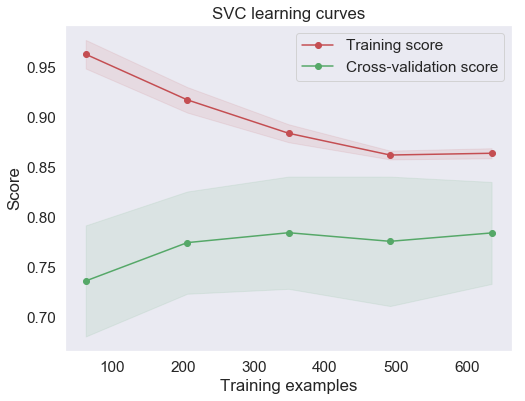

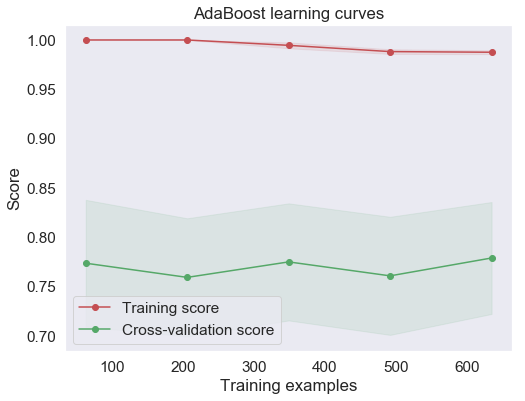

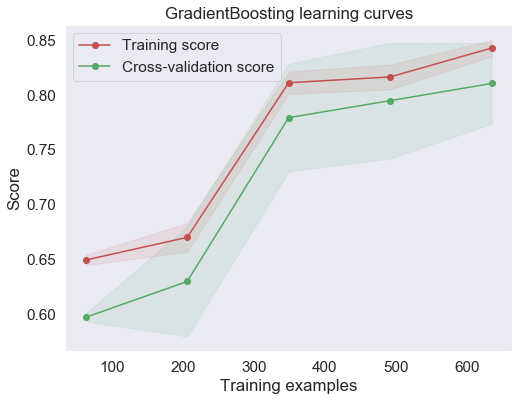

In [1037]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure(figsize = (8, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend(loc = 'best')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
kfold = 10
# g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,y_train,cv=kfold)
# g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,y_train,cv=kfold)

In [1038]:
# nrows = ncols = 2
# fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

# # names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]
# names_classifiers = [("AdaBoosting", ada_best)]
# nclassifier = 0
# for row in range(nrows):
#     for col in range(ncols):
#         name = names_classifiers[nclassifier][0]
#         classifier = names_classifiers[nclassifier][1]
#         indices = np.argsort(classifier.feature_importances_)[::-1][:40]
#         g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , 
#                         orient='h',ax=axes[row][col])
#         g.set_xlabel("Relative importance",fontsize=12)
#         g.set_ylabel("Features",fontsize=12)
#         g.tick_params(labelsize=9)
#         g.set_title(name + " feature importance")
#         nclassifier += 1